# data - kaggle - https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset
# codes - kaggle - https://www.kaggle.com/code/afsananadia/nadia-nova-brain-tumors-mri-project#A-Clean-Brain-Tumor-Dataset-for-Advanced-Medical-Research:
# https://www.kaggle.com/code/tanvirnwu/btc-v1

In [3]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
# from torchinfo import summary
import torch.optim as optim
import matplotlib.pyplot as plt

# config

In [4]:
normal_folder_path = "../Brain_Tumor_MRI/Data/Normal"
tumor_folder_path = "../Brain_Tumor_MRI/Data/Tumor"

train_size = 0.80
batch_size = 32 #크기증가 gpu활용 증가
num_epochs = 10
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cuda


# Processing File Paths of our Dataset

In [4]:
file_paths = []
labels = []

for subdir, dirs, files in os.walk(tumor_folder_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_paths.append(os.path.join(subdir, file))
            labels.append('Tumor')

# Create a dataframe
df_tumors = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})
df_tumors.shape

(18606, 2)

In [5]:
df_tumors.head()

,file_path,label
0,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
1,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
2,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
3,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
4,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor


In [6]:
normal_file_paths = []
normal_labels = []


for file in os.listdir(normal_folder_path):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        normal_file_paths.append(os.path.join(normal_folder_path, file))
        normal_labels.append('Normal')

df_normal = pd.DataFrame({
    'file_path': normal_file_paths,
    'label': normal_labels
})
df_normal.shape

(3066, 2)

In [7]:
df_merged = pd.concat([df_tumors, df_normal], ignore_index=True)
df_merged.shape

(21672, 2)

In [8]:
df_merged.head()

,file_path,label
0,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
1,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
2,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
3,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
4,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor


In [9]:
df_merged.tail()

,file_path,label
21667,../Data/Brain Tumors MRI Dataset/Normal\N_9_DA...,Normal
21668,../Data/Brain Tumors MRI Dataset/Normal\N_9_HF...,Normal
21669,../Data/Brain Tumors MRI Dataset/Normal\N_9_RO...,Normal
21670,../Data/Brain Tumors MRI Dataset/Normal\N_9_SP...,Normal
21671,../Data/Brain Tumors MRI Dataset/Normal\N_9_VF...,Normal


# Custom DataLoader

In [10]:
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        # Converting labels to'Normal' as 0 and 'Tumor' as 1
        label = torch.tensor(1 if label == 'Tumor' else 0, dtype=torch.long)
        
        return image, label

### Splitting Dataframe

In [11]:
train_df, val_df = train_test_split(df_merged, test_size=(1-train_size), random_state=42, stratify=df_merged['label'])

In [12]:
train_df.head()

,file_path,label
15783,../Data/Brain Tumors MRI Dataset/Tumor\pituita...,Tumor
12448,../Data/Brain Tumors MRI Dataset/Tumor\meningi...,Tumor
6025,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor
19851,../Data/Brain Tumors MRI Dataset/Normal\N_260_...,Normal
6275,../Data/Brain Tumors MRI Dataset/Tumor\glioma_...,Tumor


In [13]:
# head 하니까 label에 하나만 나와서 tail사용
val_df.tail()

,file_path,label
14138,../Data/Brain Tumors MRI Dataset/Tumor\pituita...,Tumor
8683,../Data/Brain Tumors MRI Dataset/Tumor\meningi...,Tumor
18670,../Data/Brain Tumors MRI Dataset/Normal\N_108_...,Normal
9663,../Data/Brain Tumors MRI Dataset/Tumor\meningi...,Tumor
8671,../Data/Brain Tumors MRI Dataset/Tumor\meningi...,Tumor


In [14]:
train_dataset = BrainTumorDataset(dataframe=train_df, transform=transform)
val_dataset = BrainTumorDataset(dataframe=val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
num_train_images = len(train_loader.dataset)
num_val_images = len(val_loader.dataset)

print(f"Number of images in the training dataloader: {num_train_images}")
print(f"Number of images in the validation dataloader: {num_val_images}")

Number of images in the training dataloader: 17337
Number of images in the validation dataloader: 4335


# Pre-trained Mode

In [16]:
def resNet50():

    ResNet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    for param in ResNet50.parameters():
        param.requires_grad = False

    for param in ResNet50.fc.parameters():
        param.requires_grad = True

    in_features = ResNet50.fc.in_features
    ResNet50.fc = nn.Linear(in_features, 2)

    return ResNet50

In [17]:
model = resNet50().to(device)
# summary(model, input_size=(32, 3, 256, 256), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

### Training Model

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

best_accuracy = 0.0
best_model_path = "../Vision/Brain_Tumor_MRI/result_model/best_model.pth"
# best_model_path = f"../Vision/Brain_Tumor_MRI/result_model/best_model.pth",batch_size,num_epochs,learning_rate
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    # Saving the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved better model with accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Train Loss: 0.2048, Validation Loss: 0.2155, Train Accuracy: 91.69%, Validation Accuracy: 90.63%
Saved better model with accuracy: 90.63%
Epoch [2/10], Train Loss: 0.1544, Validation Loss: 0.1209, Train Accuracy: 93.86%, Validation Accuracy: 95.57%
Saved better model with accuracy: 95.57%
Epoch [3/10], Train Loss: 0.1381, Validation Loss: 0.1319, Train Accuracy: 94.62%, Validation Accuracy: 95.09%
Epoch [4/10], Train Loss: 0.1262, Validation Loss: 0.1063, Train Accuracy: 95.15%, Validation Accuracy: 95.85%
Saved better model with accuracy: 95.85%
Epoch [5/10], Train Loss: 0.1275, Validation Loss: 0.1089, Train Accuracy: 95.10%, Validation Accuracy: 96.01%
Saved better model with accuracy: 96.01%
Epoch [6/10], Train Loss: 0.1178, Validation Loss: 0.1450, Train Accuracy: 95.39%, Validation Accuracy: 94.60%
Epoch [7/10], Train Loss: 0.1175, Validation Loss: 0.1018, Train Accuracy: 95.39%, Validation Accuracy: 96.08%
Saved better model with accuracy: 96.08%
Epoch [8/10], Trai

### Training & Validation Curves

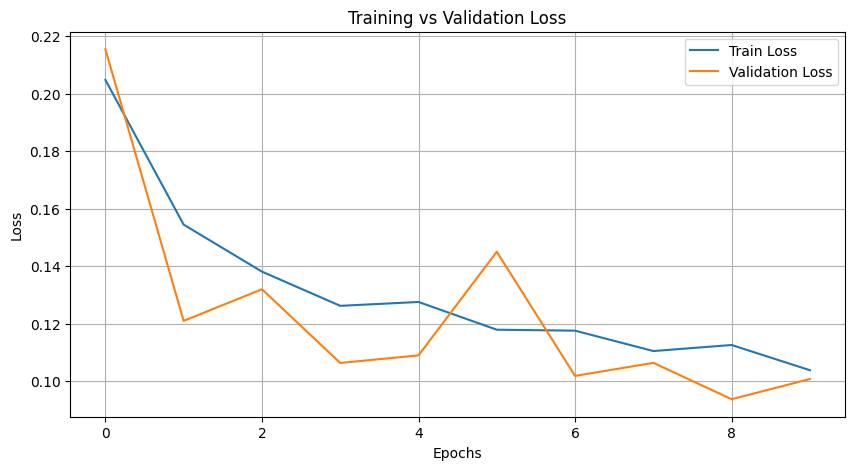

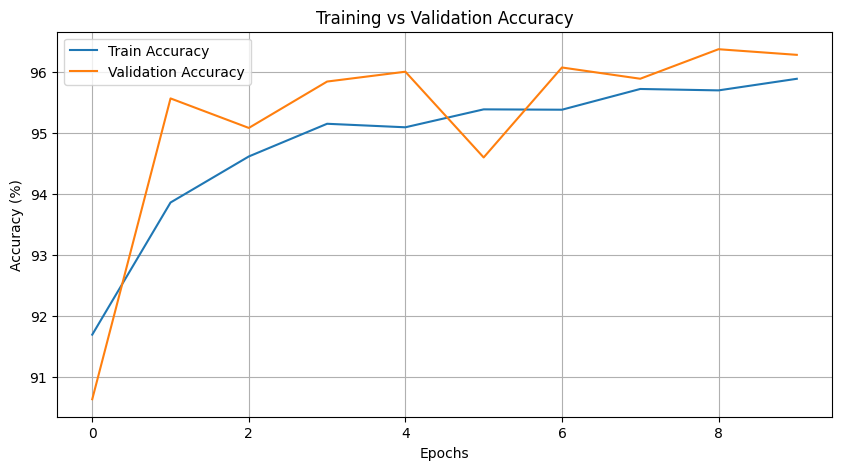

In [19]:
# Training vs Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Train vs Validation Accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

### Single Image Inference

In [20]:
from PIL import Image
from torchvision import transforms
import torch

def predict_image(image_path, model_path):
    model = resNet50()  
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0) 
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        
    classes = ['Normal', 'Tumor']
    result = classes[predicted[0]]
    print(f"The image is classified as: {result}")

In [21]:
import os
import random

# 상위 디렉토리 경로
base_directory = '../Data/Brain Tumors MRI Dataset/Tumor/'

# 하위 디렉토리 목록 가져오기
subdirectories = os.listdir(base_directory)

# 하위 디렉토리 중에서 랜덤하게 하나 선택
random_subdirectory = random.choice(subdirectories)

# 선택된 하위 디렉토리의 전체 경로
subdirectory_path = os.path.join(base_directory, random_subdirectory)

# 선택된 하위 디렉토리 안의 파일 목록 가져오기
files = os.listdir(subdirectory_path)

# 하위 디렉토리 안에서 랜덤하게 파일 선택
random_file = random.choice(files)

# 선택된 파일의 전체 경로 출력
random_file_path = os.path.join(subdirectory_path, random_file)
print("Randomly selected file:", random_file_path)


Randomly selected file: ../Data/Brain Tumors MRI Dataset/Tumor/meningioma_tumor\M_290_VF_.jpg


In [22]:
best_model_path = "../Vision/Brain_Tumor_MRI/result_model/best_model.pth"
image_path = "../Data/Brain Tumors MRI Dataset/Tumor/meningioma_tumor/M_103_BR_.jpg"

predict_image(random_file_path, best_model_path)

The image is classified as: Tumor
